In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class FiLMGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FiLMGenerator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim * 2)  # Output gamma and beta

    def forward(self, x):
        gamma_beta = self.linear(x)
        gamma, beta = torch.chunk(gamma_beta, 2, dim=1)
        return gamma, beta

class FiLMModulation(nn.Module):
    def __init__(self, feature_dim):
        super(FiLMModulation, self).__init__()
        self.feature_dim = feature_dim

    def forward(self, features, gamma, beta):
        return gamma * features + beta

class MultimodalGCNDiagnosisModel(nn.Module):
    def __init__(self, node_feature_dim, text_feature_dim):
        super(MultimodalGCNDiagnosisModel, self).__init__()
        self.gcn1 = GCNConv(node_feature_dim, 128)
        self.gcn2 = GCNConv(128, node_feature_dim)
        self.text_net = nn.LSTM(text_feature_dim, text_feature_dim, batch_first=True)
        self.film_gen = FiLMGenerator(text_feature_dim, node_feature_dim)
        self.film_mod = FiLMModulation(node_feature_dim)
        self.classifier = nn.Linear(node_feature_dim + text_feature_dim, 1)

    def forward(self, data, text):
        x, edge_index = data.x, data.edge_index

        # Process graph with GCN
        x = F.relu(self.gcn1(x, edge_index))
        gcn_features = self.gcn2(x, edge_index)

        # Process text data
        text_features, _ = self.text_net(text)
        text_features = text_features[:, -1, :]  # Get the last hidden state

        # Generate FiLM parameters
        gamma, beta = self.film_gen(text_features)

        # Modulate GCN features
        modulated_gcn_features = self.film_mod(gcn_features, gamma, beta)

        # Concatenate features and classify
        combined_features = torch.cat((modulated_gcn_features, text_features), dim=1)
        output = torch.sigmoid(self.classifier(combined_features))
        return output

# Assume we have a graph data and text data
from torch_geometric.data import Data

# Example graph data (16 nodes, each with 128 features)
node_feature_dim = 128
text_feature_dim = 64
num_nodes = 16

x = torch.randn((num_nodes, node_feature_dim))  # Node features
edge_index = torch.tensor([[0, 1, 2, 3], [1, 0, 3, 2]], dtype=torch.long)  # Example edges
data = Data(x=x, edge_index=edge_index)

# Example text data (batch_size, sequence_length, feature_dim)
text_data = torch.randn((num_nodes, 10, text_feature_dim))

# Initialize and run the model
model = MultimodalGCNDiagnosisModel(node_feature_dim, text_feature_dim)
output = model(data, text_data)
output


tensor([[0.4617],
        [0.4906],
        [0.4541],
        [0.4668],
        [0.4841],
        [0.4460],
        [0.4784],
        [0.4795],
        [0.4622],
        [0.4706],
        [0.4745],
        [0.4797],
        [0.4390],
        [0.4763],
        [0.4729],
        [0.4524]], grad_fn=<SigmoidBackward0>)

In [3]:
x

tensor([[ 0.6630,  0.9357, -0.3156,  ...,  1.2513,  0.5869,  0.9735],
        [ 0.4007,  0.8533, -1.2008,  ...,  0.7346,  2.2812, -0.5872],
        [-0.9057, -1.0698,  1.1115,  ..., -0.3800,  0.3815,  1.2993],
        ...,
        [-0.3884,  1.3591, -0.4927,  ..., -0.6187,  0.7968, -0.1485],
        [ 0.7307, -0.9129, -0.9256,  ...,  0.7461,  0.5970,  0.7456],
        [-1.9529,  0.7549, -0.9598,  ...,  0.2477, -0.7479, -0.4314]])

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

class FiLMGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FiLMGenerator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim * 2)  # Output gamma and beta

    def forward(self, x):
        gamma_beta = self.linear(x)
        gamma, beta = torch.chunk(gamma_beta, 2, dim=-1)  # Split last dimension
        return gamma, beta

class FiLMModulation(nn.Module):
    def __init__(self, feature_dim):
        super(FiLMModulation, self).__init__()
        self.feature_dim = feature_dim

    def forward(self, features, gamma, beta):
        # Reshape gamma and beta to match features
        gamma = gamma.unsqueeze(2)  # From [batch_size, num_nodes, 128] to [batch_size, num_nodes, 1, 128]
        beta = beta.unsqueeze(2)    # From [batch_size, num_nodes, 128] to [batch_size, num_nodes, 1, 128]
        gamma = gamma.expand_as(features)  # Expand to match features
        beta = beta.expand_as(features)
        return gamma * features + beta

class MultimodalGCNDiagnosisModel(nn.Module):
    def __init__(self, node_feature_dim, text_feature_dim):
        super(MultimodalGCNDiagnosisModel, self).__init__()
        self.gcn1 = GCNConv(node_feature_dim, 128)
        self.gcn2 = GCNConv(128, 128)
        self.text_net = nn.LSTM(text_feature_dim, 128, batch_first=True)
        self.film_gen = FiLMGenerator(128, 128)
        self.film_mod = FiLMModulation(128)
        self.classifier = nn.Linear(128 + 128, 2)  # Binary classification

    def forward(self, data, text):
        x, edge_index = data.x, data.edge_index

        # Process graph with GCN
        x = F.relu(self.gcn1(x, edge_index))
        gcn_features = self.gcn2(x, edge_index)

        # Reshape text data for LSTM
        batch_size, num_nodes, seq_len, text_feat_dim = text.shape
        text = text.view(batch_size * num_nodes, seq_len, text_feat_dim)

        # Process text data
        text_features, _ = self.text_net(text)
        text_features = text_features[:, -1, :]  # Get the last hidden state

        # Reshape back to (batch_size, num_nodes, -1)
        text_features = text_features.view(batch_size, num_nodes, -1)

        # Generate FiLM parameters
        gamma, beta = self.film_gen(text_features)

        # Reshape and modulate GCN features
        gcn_features = gcn_features.view(batch_size, num_nodes, 1, -1)
        modulated_gcn_features = self.film_mod(gcn_features, gamma, beta)
        modulated_gcn_features = modulated_gcn_features.view(batch_size, num_nodes, -1)

        # Concatenate features and classify
        combined_features = torch.cat((modulated_gcn_features, text_features), dim=2)
        combined_features = combined_features.mean(dim=1)  # Mean over nodes

        output = torch.sigmoid(self.classifier(combined_features))
        return output

# Example: Generate synthetic multimodal data for training
def generate_synthetic_data(num_samples, num_nodes, node_feature_dim, text_feature_dim):
    datasets = []
    for _ in range(num_samples):
        x = torch.randn((num_nodes, node_feature_dim))  # Node features
        edge_index = torch.tensor([[0, 1, 2, 3], [1, 0, 3, 2]], dtype=torch.long)  # Example edges
        data = Data(x=x, edge_index=edge_index)
        text_data = torch.randn((num_nodes, 10, text_feature_dim))  # Text data for each node
        label = torch.randint(0, 2, (1,))  # Binary label
        datasets.append((data, text_data, label))
    return datasets

# Generate a dataset
num_samples = 100  # Number of samples in the dataset
num_nodes = 16
node_feature_dim = 128
text_feature_dim = 64
dataset = generate_synthetic_data(num_samples, num_nodes, node_feature_dim, text_feature_dim)

# Define the DataLoader
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = MultimodalGCNDiagnosisModel(node_feature_dim, text_feature_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, text_data, label in dataloader:
        optimizer.zero_grad()

        # Flatten label to 1D
        label = label.view(-1)

        output = model(data, text_data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")

# Testing the model on a single batch (for demonstration)
model.eval()
with torch.no_grad():
    data, text_data, label = next(iter(dataloader))
    output = model(data, text_data)
    print(f"Predicted: {torch.argmax(output, dim=1)}, Actual: {label.view(-1)}")


Epoch 1/50, Loss: 0.6935506875698383
Epoch 2/50, Loss: 0.6869047834323003
Epoch 3/50, Loss: 0.6779846228086032
Epoch 4/50, Loss: 0.6519107176707342
Epoch 5/50, Loss: 0.5855415234198937
Epoch 6/50, Loss: 0.4596343178015489
Epoch 7/50, Loss: 0.36268092348025394
Epoch 8/50, Loss: 0.3235968534763043
Epoch 9/50, Loss: 0.3138655424118042
Epoch 10/50, Loss: 0.3138945515339191
Epoch 11/50, Loss: 0.31362664699554443
Epoch 12/50, Loss: 0.31343955718553984
Epoch 13/50, Loss: 0.31338889323748076
Epoch 14/50, Loss: 0.31336644291877747
Epoch 15/50, Loss: 0.31335220428613514
Epoch 16/50, Loss: 0.31333911648163426
Epoch 17/50, Loss: 0.3133336007595062
Epoch 18/50, Loss: 0.313327812231504
Epoch 19/50, Loss: 0.3133206848914807
Epoch 20/50, Loss: 0.3133187018907987
Epoch 21/50, Loss: 0.3133127185014578
Epoch 22/50, Loss: 0.3133096717871152
Epoch 23/50, Loss: 0.3133066159028273
Epoch 24/50, Loss: 0.3133030144067911
Epoch 25/50, Loss: 0.3133021914041959
Epoch 26/50, Loss: 0.31329862429545474
Epoch 27/50, L

Epoch 1/50, Loss: 0.6935981007722708, Accuracy: 0.5
Epoch 2/50, Loss: 0.6884293418664199, Accuracy: 0.52
Epoch 3/50, Loss: 0.6801252227563125, Accuracy: 0.59
Epoch 4/50, Loss: 0.6510430528567388, Accuracy: 0.69
Epoch 5/50, Loss: 0.5674264476849482, Accuracy: 0.78
Epoch 6/50, Loss: 0.4229386586409349, Accuracy: 0.96
Epoch 7/50, Loss: 0.3831684428911943, Accuracy: 0.95
Epoch 8/50, Loss: 0.33679988980293274, Accuracy: 0.98
Epoch 9/50, Loss: 0.3309830748117887, Accuracy: 0.99
Epoch 10/50, Loss: 0.3243740499019623, Accuracy: 0.99
Epoch 11/50, Loss: 0.32323642189686114, Accuracy: 0.99
Epoch 12/50, Loss: 0.3230056097874275, Accuracy: 0.99
Epoch 13/50, Loss: 0.3229622198985173, Accuracy: 0.99
Epoch 14/50, Loss: 0.32294052839279175, Accuracy: 0.99
Epoch 15/50, Loss: 0.32293205994826096, Accuracy: 0.99
Epoch 16/50, Loss: 0.32292741307845485, Accuracy: 0.99
Epoch 17/50, Loss: 0.32292210368009716, Accuracy: 0.99
Epoch 18/50, Loss: 0.32291911198542667, Accuracy: 0.99
Epoch 19/50, Loss: 0.3229165902

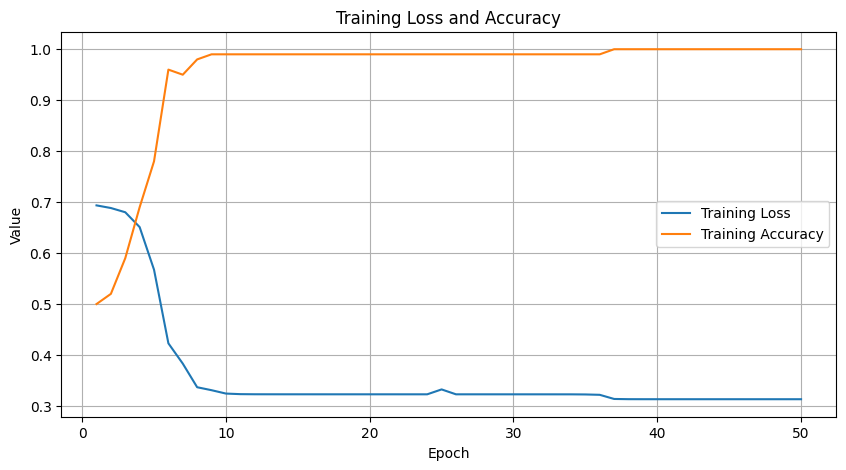

Predicted: tensor([0, 1, 0, 1, 0, 1, 0, 1]), Actual: tensor([0, 1, 0, 1, 0, 1, 0, 1])


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

class FiLMGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FiLMGenerator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim * 2)  # Output gamma and beta

    def forward(self, x):
        gamma_beta = self.linear(x)
        gamma, beta = torch.chunk(gamma_beta, 2, dim=-1)  # Split last dimension
        return gamma, beta

class FiLMModulation(nn.Module):
    def __init__(self, feature_dim):
        super(FiLMModulation, self).__init__()
        self.feature_dim = feature_dim

    def forward(self, features, gamma, beta):
        # Reshape gamma and beta to match features
        gamma = gamma.unsqueeze(2)  # From [batch_size, num_nodes, 128] to [batch_size, num_nodes, 1, 128]
        beta = beta.unsqueeze(2)    # From [batch_size, num_nodes, 128] to [batch_size, num_nodes, 1, 128]
        gamma = gamma.expand_as(features)  # Expand to match features
        beta = beta.expand_as(features)
        return gamma * features + beta

class MultimodalGCNDiagnosisModel(nn.Module):
    def __init__(self, node_feature_dim, text_feature_dim):
        super(MultimodalGCNDiagnosisModel, self).__init__()
        self.gcn1 = GCNConv(node_feature_dim, 128)
        self.gcn2 = GCNConv(128, 128)
        self.text_net = nn.LSTM(text_feature_dim, 128, batch_first=True)
        self.film_gen = FiLMGenerator(128, 128)
        self.film_mod = FiLMModulation(128)
        self.classifier = nn.Linear(128 + 128, 2)  # Binary classification

    def forward(self, data, text):
        x, edge_index = data.x, data.edge_index

        # Process graph with GCN
        x = F.relu(self.gcn1(x, edge_index))
        gcn_features = self.gcn2(x, edge_index)

        # Reshape text data for LSTM
        batch_size, num_nodes, seq_len, text_feat_dim = text.shape
        text = text.view(batch_size * num_nodes, seq_len, text_feat_dim)

        # Process text data
        text_features, _ = self.text_net(text)
        text_features = text_features[:, -1, :]  # Get the last hidden state

        # Reshape back to (batch_size, num_nodes, -1)
        text_features = text_features.view(batch_size, num_nodes, -1)

        # Generate FiLM parameters
        gamma, beta = self.film_gen(text_features)

        # Reshape and modulate GCN features
        gcn_features = gcn_features.view(batch_size, num_nodes, 1, -1)
        modulated_gcn_features = self.film_mod(gcn_features, gamma, beta)
        modulated_gcn_features = modulated_gcn_features.view(batch_size, num_nodes, -1)

        # Concatenate features and classify
        combined_features = torch.cat((modulated_gcn_features, text_features), dim=2)
        combined_features = combined_features.mean(dim=1)  # Mean over nodes

        output = torch.sigmoid(self.classifier(combined_features))
        return output

# Example: Generate synthetic multimodal data for training
def generate_synthetic_data(num_samples, num_nodes, node_feature_dim, text_feature_dim):
    datasets = []
    for _ in range(num_samples):
        x = torch.randn((num_nodes, node_feature_dim))  # Node features
        edge_index = torch.tensor([[0, 1, 2, 3], [1, 0, 3, 2]], dtype=torch.long)  # Example edges
        data = Data(x=x, edge_index=edge_index)
        text_data = torch.randn((num_nodes, 10, text_feature_dim))  # Text data for each node
        label = torch.randint(0, 2, (1,))  # Binary label
        datasets.append((data, text_data, label))
    return datasets

# Generate a dataset
num_samples = 100  # Number of samples in the dataset
num_nodes = 16
node_feature_dim = 128
text_feature_dim = 64
dataset = generate_synthetic_data(num_samples, num_nodes, node_feature_dim, text_feature_dim)

# Define the DataLoader
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = MultimodalGCNDiagnosisModel(node_feature_dim, text_feature_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
accuracies = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, text_data, label in dataloader:
        optimizer.zero_grad()

        # Flatten label to 1D
        label = label.view(-1)

        output = model(data, text_data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}, Accuracy: {accuracy}")

# Plotting the loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Testing the model on a single batch (for demonstration)
model.eval()
with torch.no_grad():
    data, text_data, label = next(iter(dataloader))
    output = model(data, text_data)
    print(f"Predicted: {torch.argmax(output, dim=1)}, Actual: {label.view(-1)}")
